# Training the model to run on Lichess data
## Some pre-requisites if running on Google Collab
If not running on Google collab do not run these next two cells!

In [ ]:
# Install the only dependency not available from collab directly
!pip install chess

# Get imported files from repo
!git clone -b rl-setup https://github.com/owenjaques/chessbot.git
!mv chessbot chessbot-repo
!mv chessbot-repo/neural_networks/chessbot .
!rm chessbot-repo -r

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')
working_directory = '/content/gdrive/MyDrive/chessbot_weights/'
print(f'Saving to {working_directory}')

## If not running on Google Collab
Set the weights directory variable to wherever you would like data saved.

In [1]:
!mkdir -p data
working_directory = './data/'

## Get the data
This compression format is really nice, so you can cancel this cell whenever you want and all the games that were downloaded will be maintained. In my experience 300Mb gets well over 100,000 games.

In [2]:
!wget https://database.lichess.org/standard/lichess_db_standard_rated_2023-02.pgn.zst

--2023-03-17 10:34:01--  https://database.lichess.org/standard/lichess_db_standard_rated_2023-02.pgn.zst
Resolving database.lichess.org (database.lichess.org)... 141.95.66.62, 2001:41d0:700:5e3e::
Connecting to database.lichess.org (database.lichess.org)|141.95.66.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31838284336 (30G) [application/octet-stream]
Saving to: ‘lichess_db_standard_rated_2023-02.pgn.zst’

  lichess_db_standa   0%[                    ] 285.76M  6.95MB/s    eta 72m 22s^C


## Decompress the Data

In [3]:
!apt install zstd
!pzstd -d lichess_db_standard_rated_2023-02.pgn.zst

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
pzstd: lichess_db_standard_rated_2023-02.pgn.zst: Incomplete block.            


## Transform the Data
For this section we create a data generator which will play the games from disk then translate them into labelled model inputs which the model will train on.

In [2]:
import chess
import chess.pgn
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from collections import deque

2023-03-17 15:06:32.318051: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 15:06:44.785488: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-17 15:06:44.785629: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-17 15:07:30.541048: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [6]:
from chessbot.model_input import ModelInput

class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, pgn_file, num_batches=128, name='training data', verbose=0):
        self.batch_size = batch_size
        self.num_batches = num_batches
        self.X_queue = deque()
        self.y_queue = deque()
        self.pgn = pgn_file
        self.n = batch_size * num_batches
        self.X = np.empty((self.n, 102))
        self.y = np.empty((self.n, 3), dtype=int)
        self.verbose = verbose
        self.name = name
        self.game_headers = []
        self.populate_Xy()

    def populate_Xy(self):
        # Plays games from the dataset and populates X and y
        
        i = 0
        while i < self.n:
            game = chess.pgn.read_game(self.pgn)
            if game is None:
                raise Exception('DataGenerator: Out of data to read from disk.')
    
            # Only train on game played to completion, that were not draws, and that have evaluations
            next_node = game.next()
            if not (game.headers['Termination'] == 'Normal' and game.headers['Result'] in ['1-0', '0-1'] and next_node and next_node.eval() != None):
                continue

            if game.headers in self.game_headers:
                raise Exception('Something has gone horribly wrong and we have a duplicate game.')
            self.game_headers.append(game.headers)

            try:
                # Generate the data from the game
                board = game.board()
                for node in game.mainline():
                    board.push(node.move)
                    self.X[i] = (ModelInput(board).get_input())
                    eval = node.eval().white().score(mate_score=10000)
                    self.y[i] = [eval <= -125, -125 < eval < 125, eval >= 125]
                    i += 1
                    
                    if self.verbose > 0:
                        print(f'\rGenerated {i}/{self.n} samples for {self.name}', end='')
            except:
                # There are a lot of reasons an exception could be thrown here, mostly stemming from bad data being parsed
                # from the pgn file. We just ignore these games and move on.
                pass

        if self.verbose > 0:
            print(f'\nNumber of losing positions: {np.sum(self.y[:, 0])}, Number of drawing positions: {np.sum(self.y[:, 1])}, Number of winning positions: {np.sum(self.y[:, 2])}')

        # For regression
        # if self.verbose > 1:
        #     _, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
        #     ax[0].hist(self.y, bins=50)
        #     ax[0].set_title(f'Labels for {self.name} (before normalising)')
        #     ax[0].set_xlabel('label (y)')
        #     ax[0].set_ylabel('no. of occurences in dataset')

        # Threshold to remove outliers and increase distribution of data
        # threshold_boundary = 1500
        # self.y[self.y > threshold_boundary] = threshold_boundary
        # self.y[self.y < -threshold_boundary] = -threshold_boundary

        # # Normalise in the range [0, 1]
        # self.y = (self.y - np.min(self.y)) / (np.max(self.y) - np.min(self.y))

        # if self.verbose > 1:
        #     ax[1].hist(self.y, bins=50)
        #     ax[1].set_title(f'Labels for {self.name} (after normalising)')
        #     ax[1].set_xlabel('label (y)')
        #     ax[1].set_ylabel('no. of occurences in dataset')
        #     plt.show()
        
    def on_epoch_end(self):
        self.populate_Xy()

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        # Returns one batch of data
        batch_idx_start = idx * self.batch_size
        batch_idx_end = idx * (self.batch_size + 1)
        return self.X[batch_idx_start:batch_idx_end], self.y[batch_idx_start:batch_idx_end]

## Our model
Set up your model being used here.

In [4]:
model = keras.Sequential([
	keras.layers.Dense(512, activation='relu'),
	keras.layers.Dense(512, activation='relu'),
	keras.layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
	metrics=['accuracy']
)

2023-03-17 15:07:56.947094: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-17 15:07:56.951056: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-17 15:07:56.952298: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-LBT75V5): /proc/driver/nvidia/version does not exist
2023-03-17 15:07:56.995240: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Training the model
This next cell trains the model on the training data, then saves it to disk. Note multiple calls to this cell have crashed the notebook before due to high RAM usages.

In [7]:
pgn_file = open('lichess_db_standard_rated_2023-02.pgn', 'r')
batch_size = 32
num_batches = 1024

training_data = DataGenerator(batch_size, pgn_file, num_batches, verbose=2)
validation_data = DataGenerator(batch_size, pgn_file, int(num_batches*0.2), name='validation data', verbose=2)

Generated 32768/32768 samples for training data
Number of losing positions: 9316, Number of drawing positions: 13284, Number of winning positions: 10168
Generated 6528/6528 samples for validation data
Number of losing positions: 1676, Number of drawing positions: 2866, Number of winning positions: 1986


In [8]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    patience=20,
    verbose=1)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=0.000000000000001,
    verbose=1)

checkpoint = keras.callbacks.ModelCheckpoint(
    f'{working_directory}lichess_trained_model',
    monitor='val_loss',
    save_best_only=True)

tensorboard = keras.callbacks.TensorBoard(
    log_dir=f'{working_directory}/logs',
    write_graph=True,
    write_images=True,
    histogram_freq=1)

model.fit(
    training_data,
    epochs=128,
    shuffle=True,
    validation_data=validation_data,
    callbacks=[early_stopping, reduce_lr, checkpoint, tensorboard])

Epoch 1/128
Generated 6528/6528 samples for validation dataETA: 0s - loss: 0.9653 - accuracy: 0.5025
Number of losing positions: 2094, Number of drawing positions: 2731, Number of winning positions: 1703


INFO:tensorflow:Assets written to: ./data/lichess_trained_model/assets


INFO:tensorflow:Assets written to: ./data/lichess_trained_model/assets


32768/32768 [==============================] - 862s 26ms/step - loss: 0.9653 - accuracy: 0.5025 - val_loss: 1.0585 - val_accuracy: 0.5106 - lr: 0.0010
Generated 32768/32768 samples for training data
Number of losing positions: 9074, Number of drawing positions: 13291, Number of winning positions: 10403
Epoch 2/128
Generated 6528/6528 samples for validation dataETA: 0s - loss: 0.9248 - accuracy: 0.5306
Number of losing positions: 1861, Number of drawing positions: 2796, Number of winning positions: 1871


INFO:tensorflow:Assets written to: ./data/lichess_trained_model/assets


INFO:tensorflow:Assets written to: ./data/lichess_trained_model/assets


32768/32768 [==============================] - 808s 25ms/step - loss: 0.9248 - accuracy: 0.5306 - val_loss: 0.9110 - val_accuracy: 0.4897 - lr: 0.0010
Generated 32768/32768 samples for training data
Number of losing positions: 8613, Number of drawing positions: 13074, Number of winning positions: 11081
Epoch 3/128
Generated 6528/6528 samples for validation dataETA: 0s - loss: 0.9061 - accuracy: 0.5251
Number of losing positions: 1866, Number of drawing positions: 2813, Number of winning positions: 1849


INFO:tensorflow:Assets written to: ./data/lichess_trained_model/assets


INFO:tensorflow:Assets written to: ./data/lichess_trained_model/assets


32768/32768 [==============================] - 818s 25ms/step - loss: 0.9061 - accuracy: 0.5251 - val_loss: 0.8905 - val_accuracy: 0.5257 - lr: 0.0010
Generated 32768/32768 samples for training data
Number of losing positions: 8784, Number of drawing positions: 13222, Number of winning positions: 10762
Epoch 4/128
Generated 6528/6528 samples for validation dataETA: 0s - loss: 0.9098 - accuracy: 0.5426
Number of losing positions: 1833, Number of drawing positions: 2641, Number of winning positions: 2054
32768/32768 [==============================] - 962s 29ms/step - loss: 0.9098 - accuracy: 0.5426 - val_loss: 0.8911 - val_accuracy: 0.5299 - lr: 0.0010
Generated 32768/32768 samples for training data
Number of losing positions: 8997, Number of drawing positions: 13964, Number of winning positions: 9807
Epoch 5/128
Generated 6528/6528 samples for validation dataETA: 0s - loss: 0.9000 - accuracy: 0.5489
Number of losing positions: 1875, Number of drawing positions: 2347, Number of winning p

KeyboardInterrupt: 

### Launch tensorboad

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir /content/gdrive/MyDrive/chessbot_weights/logs/train

### Optionally load a previous model

In [ ]:
model = keras.models.load_model(f'{working_directory}/lichess_trained_model')

### Confusion Matrix

204/204 [==============================] - 15s 72ms/step
[[0.00344726 0.9735882  0.02296452]
 [0.00560888 0.961328   0.03306316]
 [0.00592373 0.960331   0.03374519]
 ...
 [0.41527772 0.10754994 0.47717232]
 [0.41527772 0.10754994 0.47717232]
 [0.41527772 0.10754994 0.47717232]]


[Text(0.5, 23.52222222222222, 'Predicted label'),
 Text(50.722222222222214, 0.5, 'True label')]

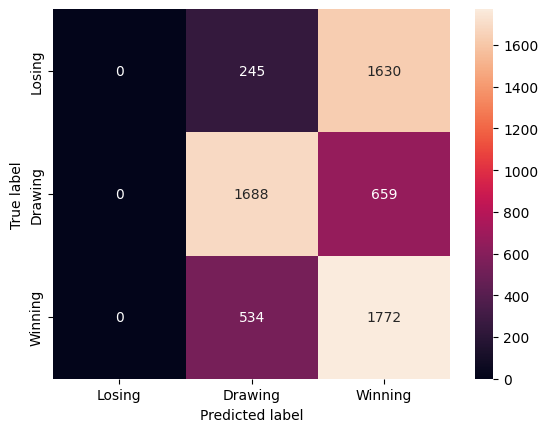

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plot the confusion matrix for the validation data
y_pred = model.predict(validation_data.X)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(validation_data.y, axis=1)
cm = confusion_matrix(y_true, y_pred)

ax = sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Losing', 'Drawing', 'Winning'], yticklabels=['Losing', 'Drawing', 'Winning'])
ax.set(xlabel='Predicted label', ylabel='True label')

## Why not play a game after all that training?

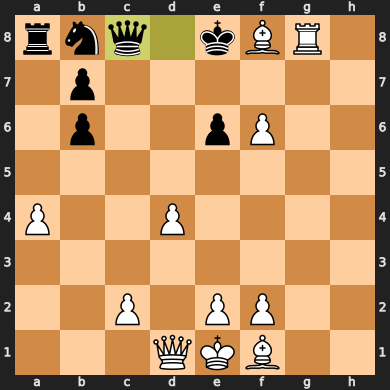

'1/2-1/2'

In [11]:
import time
from IPython.display import clear_output
from importlib import reload
import chessbot.chessbot
reload(chessbot.chessbot)
from chessbot.chessbot import ChessBot

def play_game(model, exploration_rate=0.0, should_visualise=False):
	white = ChessBot(model, chess.WHITE, exploration_rate)
	black = ChessBot(model, chess.BLACK, exploration_rate)

	board = chess.Board()

	if should_visualise:
		display(board)

	while not board.is_game_over(claim_draw=True):
		board.push(black.move(board) if board.turn == chess.BLACK else white.move(board))

		if should_visualise:
			time.sleep(1)
			clear_output(wait=True)
			display(board)

	return board.outcome(claim_draw=True).result()
 
play_game(model, should_visualise=True)